The goal of this project is to analyze a dataset to determine if there exists a connection between driving conditions and an electric vehicle’s battery temperature. The expected model contains two inputs: the ambient temperature and the trip distance, and the output is the battery temperature. The statistical method that will be considered for this analysis is linear regression and sampling will be applied to verify the conclusions drawn from the dataset

In [1]:
# Import necessary libraries = common libraries include pandas, numpy, matplotlib, sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import math
import statistics as stats
import statsmodels.stats.api as sms
#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
#Importing PCA
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

## **Data Cleaning:**
1. import the data into a dataframe
2. review the data
3. determine the data set to only use for the model to be built on
4. use only the data asked in the question
5. confirm each column has all the data per column
6. if not all data in the column, make sample the data so that value count equal the other columns

In [2]:
#import data
evbattemp = pd.read_excel('EvBatTemps.xlsx')

In [3]:
#review the data
# view the first 5 records of each column
evbattemp.head()

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Unnamed: 8,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Unnamed: 13,Fan,Note
0,TripA01,2019-06-25_13-21-14,Munich East,sunny,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,NaN,"Automatic, Level 1",NaN
1,TripA02,2019-06-25_14-05-31,Munich East,sunny,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,NaN,"Automatic, Level 1",Target Cabin Temperature changed
2,TripA03,2019-06-28_10-02-15,Munich East,sunny,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,NaN,"Automatic, Level 1",Target Cabin Temperature changed
3,TripA04,2019-06-28_10-13-30,Munich East,sunny,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,NaN,"Automatic, Level 1",NaN
4,TripA05,2019-06-28_10-20-26,Munich East,sunny,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,NaN,"Automatic, Level 1",NaN


**Observations:**
- There are 2 unamed columns

In [4]:
#review the data
# confirm the data info
evbattemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Trip                              70 non-null     object 
 1   Date                              70 non-null     object 
 2   Route/Area                        70 non-null     object 
 3   Weather                           70 non-null     object 
 4   Battery Temperature (Start) [°C]  70 non-null     float64
 5   Battery Temperature (End)         70 non-null     float64
 6   Battery State of Charge (Start)   70 non-null     float64
 7   Battery State of Charge (End)     70 non-null     float64
 8   Unnamed: 8                        70 non-null     float64
 9   Ambient Temperature (Start) [°C]  70 non-null     float64
 10  Target Cabin Temperature          70 non-null     float64
 11  Distance [km]                     70 non-null     float64
 12  Duration [

**Observations:**
- There are **72 rows** and **16 columns** in the data.
- Though there are **72 rows** for majority of columns, only 70 of them show up and non-null, confirm 2 rows are null and remove them.
- The column "Unnamed: 13" has no values in it.
- The column "Note" has only 26 rows out of the average total of 72 rows compared to the rest of the columns.
- Columns "Unnamed: 13" and "Note" can be dropped because they do not have enough data to be used for further analysis.
- Columns "Trip" and "Date" can be dropped because they do not include data specific to "driving conditions".
- As per the requirements, remove the row with column 'Change_In_Battery_State_of_Charge' value negative.

In [5]:
# drop the 2 columns: 'Note', 'Unnamed: 13'
#evbattemp = evbattemp.drop(['Trip','Date','Note', 'Unnamed: 13', 'Fan'], axis=1)
evbattemp = evbattemp.drop(['Unnamed: 13','Note','Trip','Date'], axis=1)

In [6]:
#find unique values per variable
evbattemp.nunique(axis=0)

Route/Area                           9
Weather                              8
Battery Temperature (Start) [°C]    30
Battery Temperature (End)           24
Battery State of Charge (Start)     61
Battery State of Charge (End)       66
Unnamed: 8                          64
Ambient Temperature (Start) [°C]    40
Target Cabin Temperature            12
Distance [km]                       70
Duration [min]                      70
Fan                                  2
dtype: int64

**Observations:**
- Some of the columns are of **numeric data type** while others are of **object data type**, we need to confirm if the object columns are categorical and determine if they need to be removed during data preparation phase
- For columns "Route/Area", "Fan", and "Weather" the data is categorical, convert the column to category data type
- For columns "Route/Area", "Fan", and "Weather", after converting to category, convert the category into codes for better analysis
- The column "Fan" has 2 values
- The columns "Trip", "Distance [km]", and "Duration [min]" have 70 rows each in them, we will need to determine if they are dependent or independent variables
- The column "Date" has 69 unique rows

In [7]:
# confirm null rows exists
evbattemp_null_only = evbattemp[evbattemp.isna().any(axis=1)]
evbattemp_null_only

,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Unnamed: 8,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations:**
- Confirmed earlier assumptions that there are 2 empty rows
- Drop the empty rows

In [8]:
#drop null rows
evbattemp = evbattemp.dropna(how='any',axis=0)

In [9]:
# confirm no null rows exists
evbattemp_null_only1 = evbattemp[evbattemp.isna().any(axis=1)]
evbattemp_null_only1

,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Unnamed: 8,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan


In [10]:
#confirm there are no more rows with missing values
evbattemp.isnull().sum()

Route/Area                          0
Weather                             0
Battery Temperature (Start) [°C]    0
Battery Temperature (End)           0
Battery State of Charge (Start)     0
Battery State of Charge (End)       0
Unnamed: 8                          0
Ambient Temperature (Start) [°C]    0
Target Cabin Temperature            0
Distance [km]                       0
Duration [min]                      0
Fan                                 0
dtype: int64

In [11]:
# confirm null rows were removed
evbattemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 71
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Route/Area                        70 non-null     object 
 1   Weather                           70 non-null     object 
 2   Battery Temperature (Start) [°C]  70 non-null     float64
 3   Battery Temperature (End)         70 non-null     float64
 4   Battery State of Charge (Start)   70 non-null     float64
 5   Battery State of Charge (End)     70 non-null     float64
 6   Unnamed: 8                        70 non-null     float64
 7   Ambient Temperature (Start) [°C]  70 non-null     float64
 8   Target Cabin Temperature          70 non-null     float64
 9   Distance [km]                     70 non-null     float64
 10  Duration [min]                    70 non-null     float64
 11  Fan                               70 non-null     object 
dtypes: float64

**Observations:**
- confirmed that Null rows were removed
- Still have 3 columns listed with data types as "object"
- Column names should be standardized
- Rename the unamed column

In [12]:
# rename column 'Unnamed: 8'
evbattemp.rename(columns={'Unnamed: 8':'Change_In_Battery_State_of_Charge'}, inplace=True)

**Observations**
- Remove row of with column "Change_In_Battery_State_of_Charge" having a negative value as per the requirements.

In [13]:
# remove column with 'Change In Battery State of Charge'
# should always be positive
# if negative remove because it shows that the battery charge in between the trip time 
#  and that is outside the scope of the analysis

evbattemp.drop(evbattemp[evbattemp['Change_In_Battery_State_of_Charge'] < 0].index, inplace=True)

**Observations**
- Rename columns with non-alpanumeric and replace spaces with underscores for easier usability

In [14]:
# rename columns with non-alpanumeric and replace spaces with underscores for easier usability
evbattemp.rename(columns={'Route/Area':'Route_Area'}, inplace=True)
evbattemp.rename(columns={'Weather':'Weather'}, inplace=True)
evbattemp.rename(columns={'Battery Temperature (Start) [°C]':'Battery_Temperature_Start_Celsius'}, inplace=True)
evbattemp.rename(columns={'Battery Temperature (End)':'Battery_Temperature_End'}, inplace=True)
evbattemp.rename(columns={'Battery State of Charge (Start)':'Battery_State_of_Charge_Start'}, inplace=True)
evbattemp.rename(columns={'Battery State of Charge (End)':'Battery_State_of_Charge_End'}, inplace=True)
evbattemp.rename(columns={'Ambient Temperature (Start) [°C]':'Ambient_Temperature_Start_Celsius'}, inplace=True)
evbattemp.rename(columns={'Target Cabin Temperature':'Target_Cabin_Temperature'}, inplace=True)
evbattemp.rename(columns={'Distance [km]':'Distance_km'}, inplace=True)
evbattemp.rename(columns={'Duration [min]':'Duration_min'}, inplace=True)

In [15]:
# Confirm the record was removed and column names were changed
evbattemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 71
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Route_Area                         69 non-null     object 
 1   Weather                            69 non-null     object 
 2   Battery_Temperature_Start_Celsius  69 non-null     float64
 3   Battery_Temperature_End            69 non-null     float64
 4   Battery_State_of_Charge_Start      69 non-null     float64
 5   Battery_State_of_Charge_End        69 non-null     float64
 6   Change_In_Battery_State_of_Charge  69 non-null     float64
 7   Ambient_Temperature_Start_Celsius  69 non-null     float64
 8   Target_Cabin_Temperature           69 non-null     float64
 9   Distance_km                        69 non-null     float64
 10  Duration_min                       69 non-null     float64
 11  Fan                                69 non-null     object 
d

**Observations**
- Change the columns with "Object" data types to "Category" for meaningful grouping

In [16]:
# change data types of category columns
evbattemp['Route_Area'] = evbattemp['Route_Area'].astype('category')
evbattemp['Weather'] = evbattemp['Weather'].astype('category')
evbattemp['Fan'] = evbattemp['Fan'].astype('category')

In [17]:
# confirm the date type change for the category columns
evbattemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 71
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Route_Area                         69 non-null     category
 1   Weather                            69 non-null     category
 2   Battery_Temperature_Start_Celsius  69 non-null     float64 
 3   Battery_Temperature_End            69 non-null     float64 
 4   Battery_State_of_Charge_Start      69 non-null     float64 
 5   Battery_State_of_Charge_End        69 non-null     float64 
 6   Change_In_Battery_State_of_Charge  69 non-null     float64 
 7   Ambient_Temperature_Start_Celsius  69 non-null     float64 
 8   Target_Cabin_Temperature           69 non-null     float64 
 9   Distance_km                        69 non-null     float64 
 10  Duration_min                       69 non-null     float64 
 11  Fan                                69 non-null 

**Observatons**
- Data is cleaned now add the calculated columns as per requirements

In [18]:
# convert the category date type columns to ordinal values
# first create temp data set to handle the conversion
#evbattemp_cat_columns = evbattemp.select_dtypes(['category']).columns

In [19]:
# convert the category date type columns to ordinal values
# second perform the category data type conversion
#evbattemp[evbattemp_cat_columns] = evbattemp[evbattemp_cat_columns].apply(lambda x: x.cat.codes)

In [20]:
# convert the category date type columns to ordinal values
# confirm the conversion was successfull
# evbattemp.head()

In [21]:
# confirm the date type change for the category columns
#evbattemp.info()

In [22]:
# convert category columns to float to match the continous data just like the columns for better analysis
# change data types of category columns
#evbattemp['Route_Area'] = evbattemp['Route_Area'].astype('float64')
#evbattemp['Weather'] = evbattemp['Weather'].astype('float64')

In [23]:
# confirm the date type change for the category columns
#evbattemp.info()

## **Exploratory Data Analysis:**
- Review unique values in each column
- Perform Univariate Analysis for numerical and categorical columns
- Perform Bivariate Analysis against numerical calculated columns and categorical columns
- Perform Multivariate Analysis for data visualization of correlationa
- Perform a Principal Component Analysis for further verification of correlation between Dependent and Independent variables

In [24]:
# Checking unique values in each column
evbattemp.nunique()

Route_Area                            8
Weather                               8
Battery_Temperature_Start_Celsius    30
Battery_Temperature_End              24
Battery_State_of_Charge_Start        60
Battery_State_of_Charge_End          65
Change_In_Battery_State_of_Charge    63
Ambient_Temperature_Start_Celsius    39
Target_Cabin_Temperature             12
Distance_km                          69
Duration_min                         69
Fan                                   2
dtype: int64

**Observatons**
- "Route_Area" and "Weather" columns have only 8 unique values out of 70 rows, this would suggest these values are ordinal
- "Fan" column has only 2 unique values out of 70 rows, this would suggest these values are ordinal
- "Target_Cabin_Temperature" column has only 12 unique values out of 70 rows, this would suggest these values are intervals
- "Battery_Temperature_Start_Celsius", "Battery_Temperature_End", and "Ambient_Temperature_Start_Celsius" columns have less than 40 unique values out of 70 rows, this would suggest these values are intervals
- The rest of the other columns not list in the observations have close to 70 rows and this would sugesst these values are ratio

### **Univariate analysis of numerical columns**

In [25]:
#create data set for numerical columns only for analysis
evbattemp_numerical = evbattemp.drop(['Route_Area', 'Weather','Fan'], axis = 1)

In [26]:
# Checking summary statistics
evbattemp_numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
Battery_Temperature_Start_Celsius,69.0,14.289855,7.784036,-1.000000,8.000000,14.0000,20.000000,30.000000
Battery_Temperature_End,69.0,16.536232,6.616778,3.000000,11.000000,15.0000,21.000000,30.000000
Battery_State_of_Charge_Start,69.0,0.732348,0.141920,0.315000,0.674000,0.7550,0.848000,0.885000
Battery_State_of_Charge_End,69.0,0.597667,0.165625,0.154000,0.504000,0.6370,0.715000,0.829000
Change_In_Battery_State_of_Charge,69.0,0.145319,0.111361,0.019000,0.081000,0.1220,0.161000,0.719000
Ambient_Temperature_Start_Celsius,69.0,12.413043,9.935437,-3.000000,3.500000,7.5000,21.500000,33.500000
Target_Cabin_Temperature,69.0,23.485507,2.523377,21.000000,22.000000,22.0000,25.000000,33.000000
Distance_km,69.0,19.394547,11.696113,2.782300,12.393223,16.4252,19.370888,60.974700
Duration_min,69.0,25.728768,14.634992,5.906667,16.820000,23.3800,30.370000,93.501667


**Observations:**
- Each column has a count of 69 values
- Columns with continous data values "Battery_State_of_Charge_Start", "Battery_State_of_Charge_End", "Change_In_Battery_State_of_Charge","Distance_km", "Duration_min", "Ambient_Temperature_Start_Celsius"
- The average distance traveled is 19.4 kilometers
- The average duration of travel is 25.72 minutes

**Let's explore these variables in some more depth by observing their distributions**

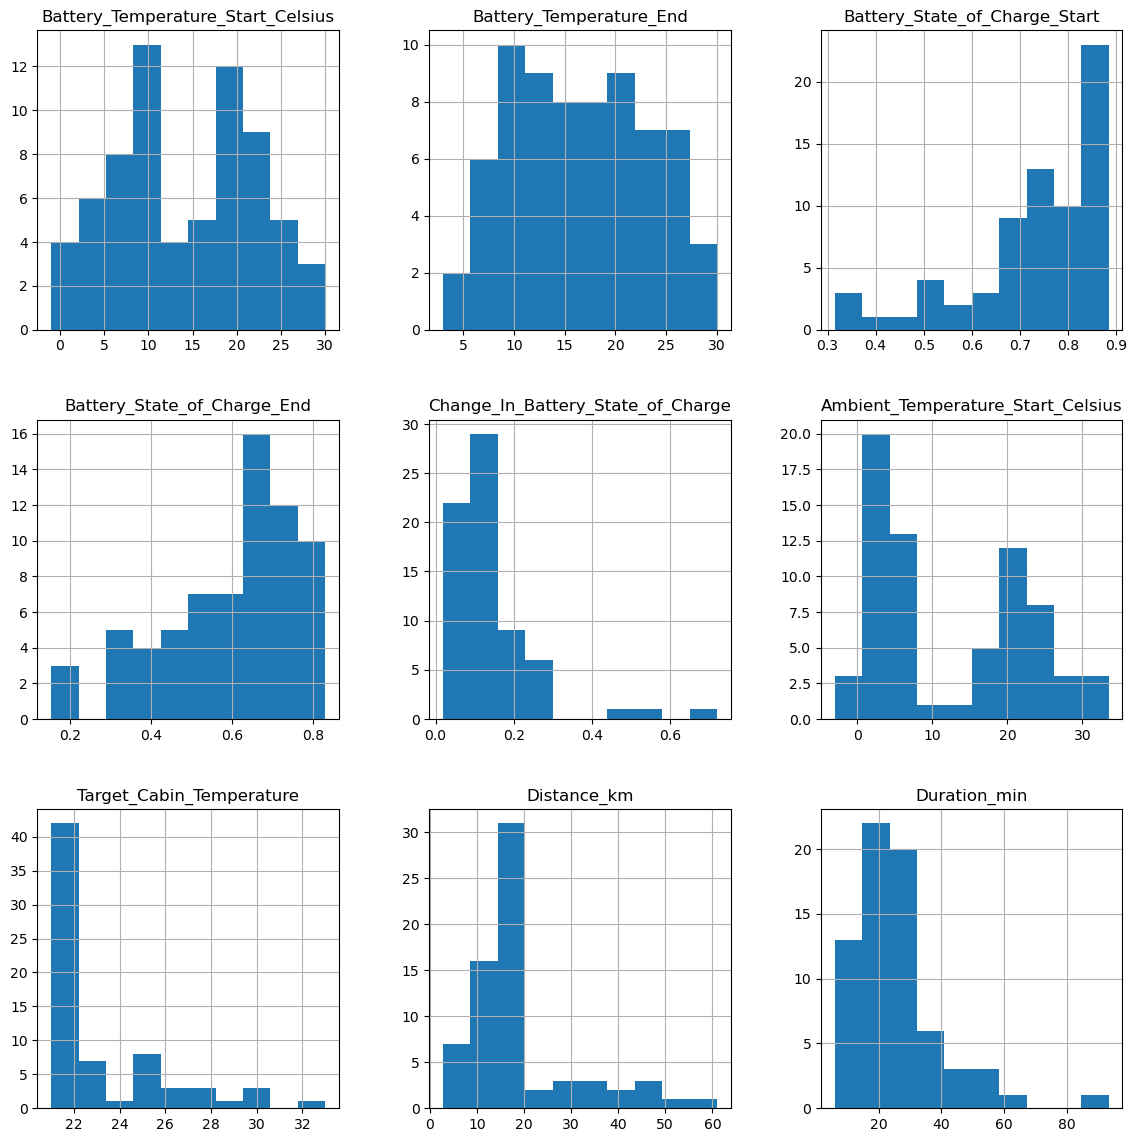

In [27]:
# Creating histograms
evbattemp.hist(figsize=(14,14))
plt.show()

**Observations:**

- **Battery_Temperature_Start_Celsius** has a bimodal distribution.

- **Battery_Temperature_End** has a uniform distribution.

- **Battery_State_of_Charge_Start** is leftly skewed.

- **Battery_State_of_Charge_End** is also leftly skewed and shows that not much energy from the battery is being drained during travel. 

- **Change_In_Battery_State_of_Charge** is rightly skewed and with a small standard deviation, this confirms not much energy from battery is being used during travel.

- **Ambient_Temperature_Start_Celsius** has a bimodal distribution.

- **Target_Cabin_Temperature** is leftly skewed. 

- **Distance_km** has normal distribution and most distance travel is 20KM or less.

- **Duration_min** is leftly skewed with most duration of travel less than 40 minutes.

### **Univariate analysis for categorical variables**

In [28]:
# group ordinal and nominal values in data frame for analysis
#Create new columnar data sets to be used for Exploratory Data Analysis

# Creating ratio columns
# all numbers are meaningful, including zeros and the difference matters
ratio_cols=['Distance_km','Duration_min']

# Creating interval columns
# zero values are arbitrary but the difference matters
interval_cols= ['Battery_Temperature_Start_Celsius','Battery_Temperature_End','Battery_State_of_Charge_Start', 
                'Battery_State_of_Charge_End','Change_In_Battery_State_of_Charge', 'Ambient_Temperature_Start_Celsius',
                'Target_Cabin_Temperature','Battery_State_of_Charge_Rate','Battery_Rate_of_Heating']

# Creating ordinal columns
# Columns used to help describe the other data
ordinal_cols= ['Route_Area','Weather', 'Fan']

In [29]:
# Printing the % sub categories of each category
for i in ordinal_cols:
    print(evbattemp[i].value_counts(normalize=True))
    print('*'*40)

Munich East         0.449275
Munich North        0.304348
FTMRoute            0.101449
Highway             0.043478
Munich South        0.043478
Munich Northeast    0.028986
FTMRoute (2x)       0.014493
FTMRoute reverse    0.014493
Name: Route_Area, dtype: float64
****************************************
sunny                 0.376812
slightly cloudy       0.289855
cloudy                0.173913
dark                  0.057971
sunrise               0.043478
rainy                 0.028986
dark, little rainy    0.014493
sunset                0.014493
Name: Weather, dtype: float64
****************************************
Automatic, Level 1                                         0.985507
Automatic, Level 1 (screen defrost for the first 2 min)    0.014493
Name: Fan, dtype: float64
****************************************


**Observatons**
- For column "Route_Area", values "Munich East" and "Munich North" are the most used
- For column "Weather", values "Sunny", "Slightly Cloudy", and "Cloudy" are the most used
- For column "Fan", value "Automatic, Level 1" is used 98% of the time

### **Bivariate Analysis**
- We have analyzed the numerical and categorical variables individually. Let's now check how "Battery_Temperature_End" is related with the 2 categorical variables.
- Compare categorical variables with numericals that are thought to be duplicates

**Bar Plot Analysis**
- shows the relationship between "Battery_Temperature_End" and categorical columns on an individual basis

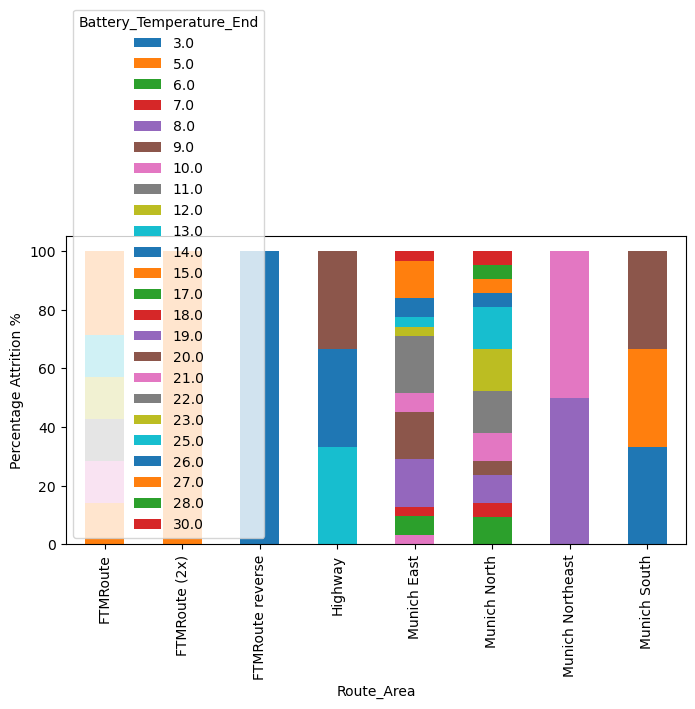

In [30]:
ordinal_cols_with_end_bat_temp = ['Route_Area','Battery_Temperature_End']
for i in ordinal_cols_with_end_bat_temp:
    if i!='Battery_Temperature_End':
        (pd.crosstab(evbattemp[i],evbattemp['Battery_Temperature_End'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Attrition %')

**Observatons**
- For column "Route_Area", values "Munich East" and "Munich North" have the most variations of "Battery Temperature End"

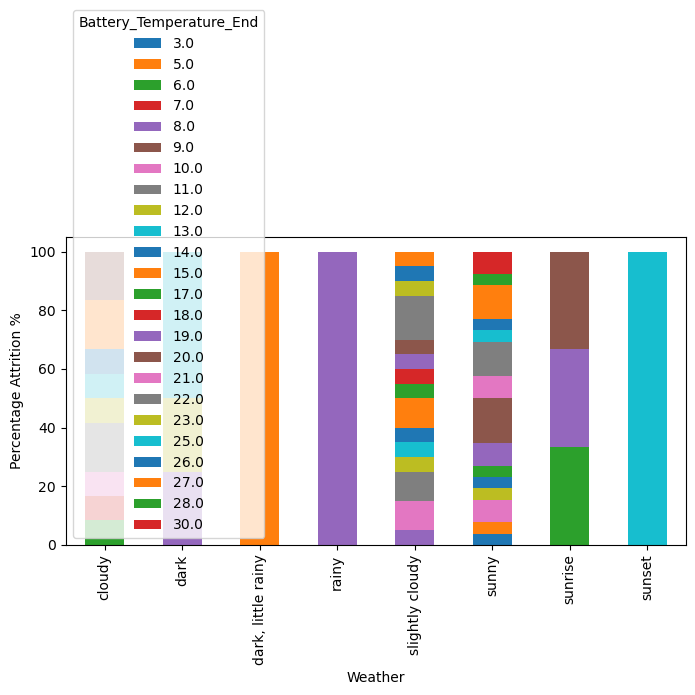

In [31]:
ordinal_cols_with_end_bat_temp = ['Weather','Battery_Temperature_End']
for i in ordinal_cols_with_end_bat_temp:
    if i!='Battery_Temperature_End':
        (pd.crosstab(evbattemp[i],evbattemp['Battery_Temperature_End'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Attrition %')

**Observatons**
- For column "Weather", values "Sunny" and "Slightly Cloudy" have the most variations of "Battery Temperature End"

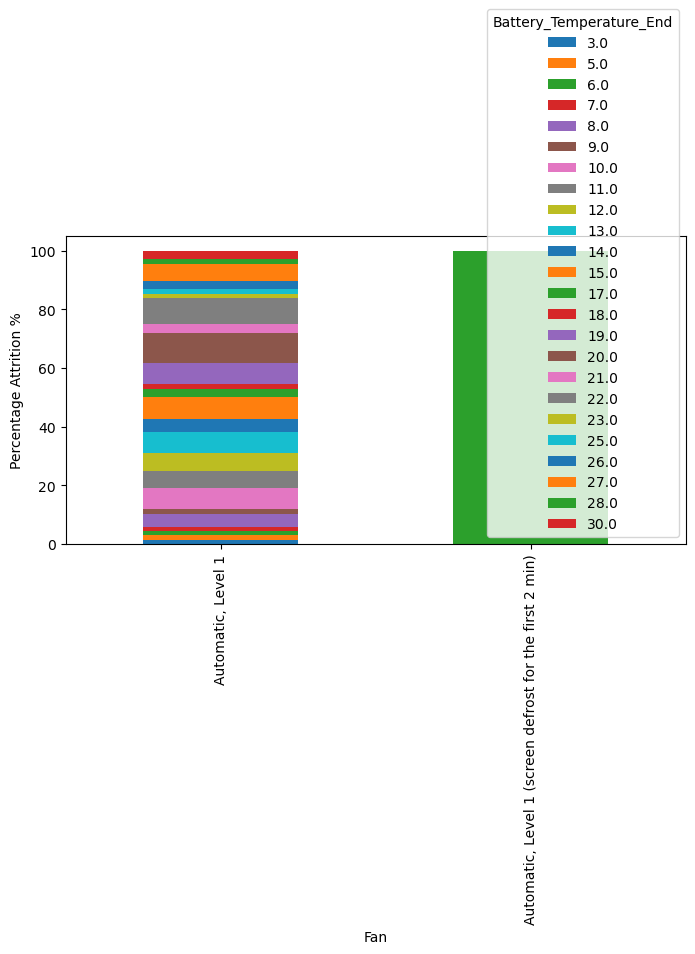

In [32]:
ordinal_cols_with_end_bat_temp = ['Fan','Battery_Temperature_End']
for i in ordinal_cols_with_end_bat_temp:
    if i!='Battery_Temperature_End':
        (pd.crosstab(evbattemp[i],evbattemp['Battery_Temperature_End'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Attrition %')

**Observatons**
- For column "Fan", value "Automatic, Level 1" has the most variations of "Battery Temp End"

**Box Plot Analysis**
- shows the relationship between "Distance_km", "Ambient_Temperature_Start_Celsius", and "Target_Cabin_Temperature" and categorical columns on an individual basis
- to confirm likeness in data

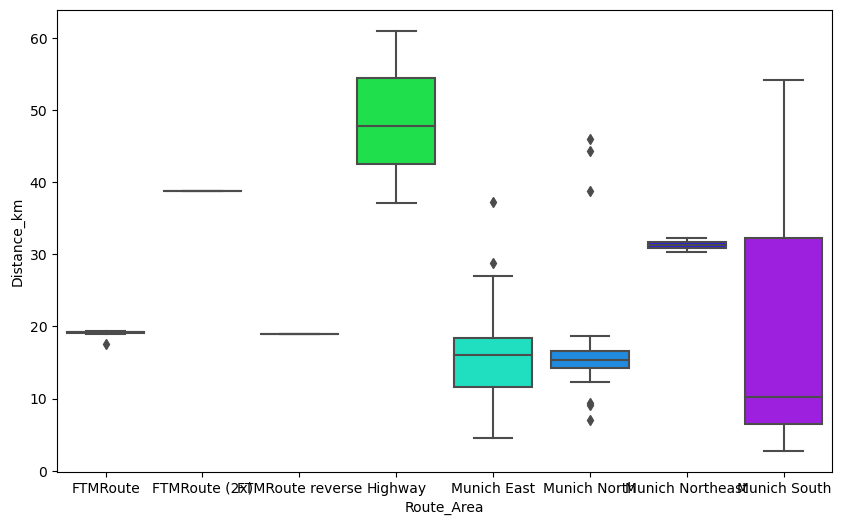

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=evbattemp, x='Route_Area', y='Distance_km', palette="gist_rainbow"
)
plt.show() 

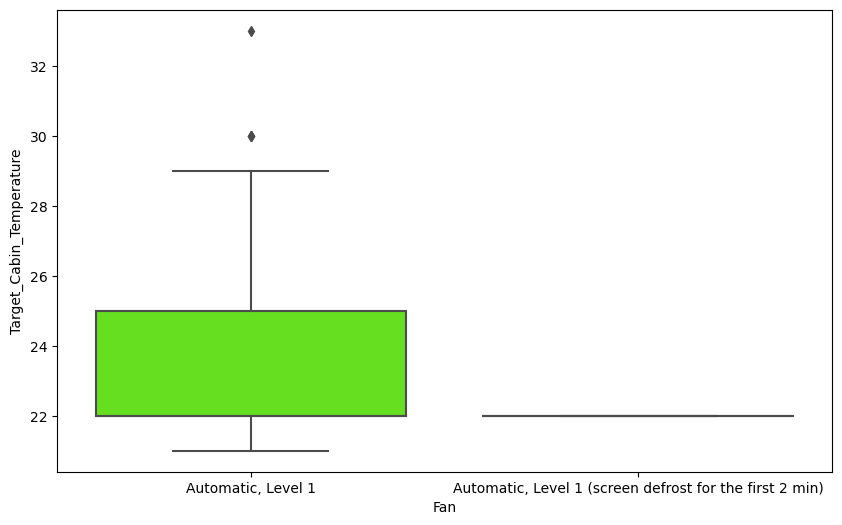

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=evbattemp, x='Fan', y='Target_Cabin_Temperature', palette="gist_rainbow"
)
plt.show() 

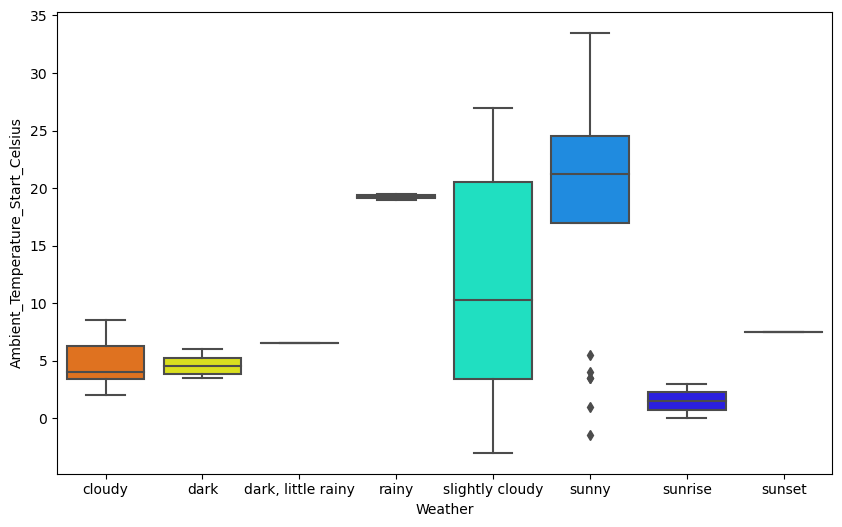

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=evbattemp, x='Weather', y='Ambient_Temperature_Start_Celsius', palette="gist_rainbow"
)
plt.show() 

**Observatons**
- All categorical columns can be removed because their data describes the numerical values of which they've been compared against. 

**Scatter Plot Analysis**
- shows the relationship between "Battery_Temperature_End" and other numerical columns on an individual basis
- helps determine if a linear model is needed or if some other model should be used

<Figure size 1000x500 with 0 Axes>

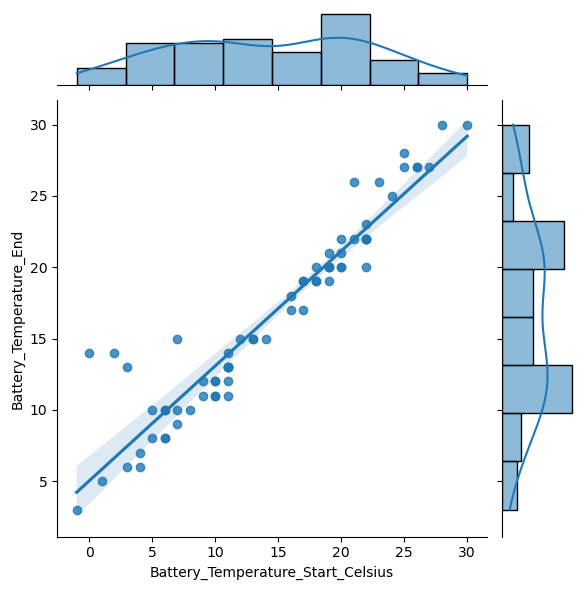

In [36]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Battery_Temperature_Start_Celsius', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

<Figure size 1000x500 with 0 Axes>

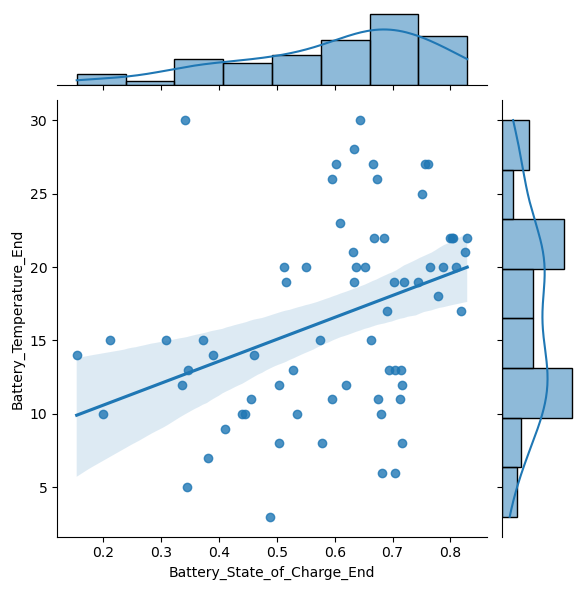

In [37]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Battery_State_of_Charge_End', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

<Figure size 1000x500 with 0 Axes>

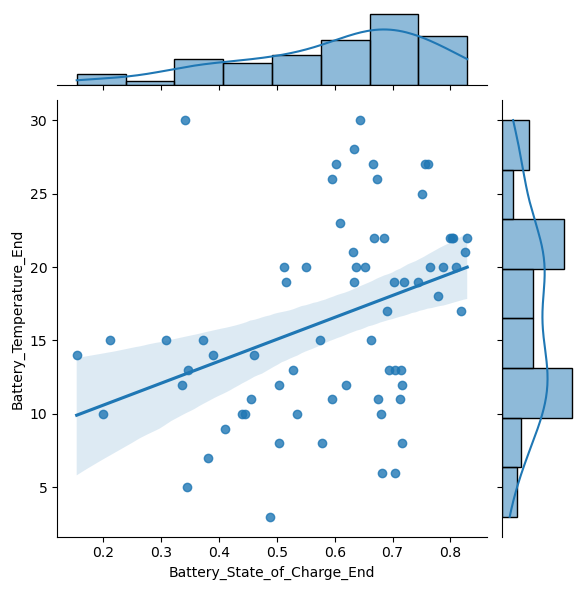

In [38]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Battery_State_of_Charge_End', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

<Figure size 1000x500 with 0 Axes>

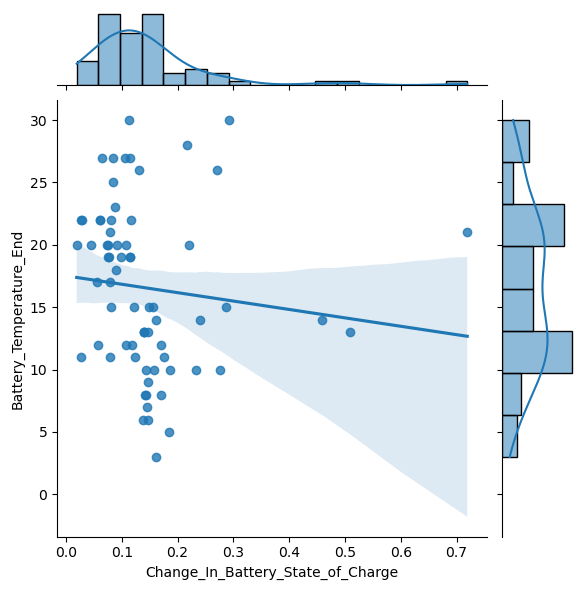

In [39]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Change_In_Battery_State_of_Charge', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

<Figure size 1000x500 with 0 Axes>

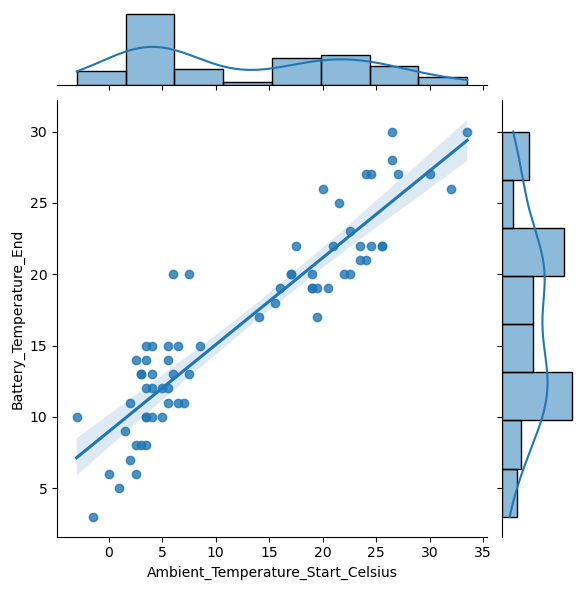

In [40]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Ambient_Temperature_Start_Celsius', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

<Figure size 1000x500 with 0 Axes>

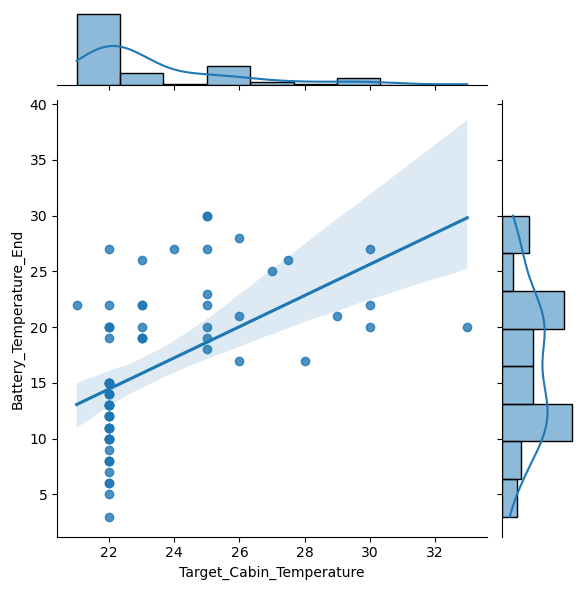

In [41]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Target_Cabin_Temperature', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

<Figure size 1000x500 with 0 Axes>

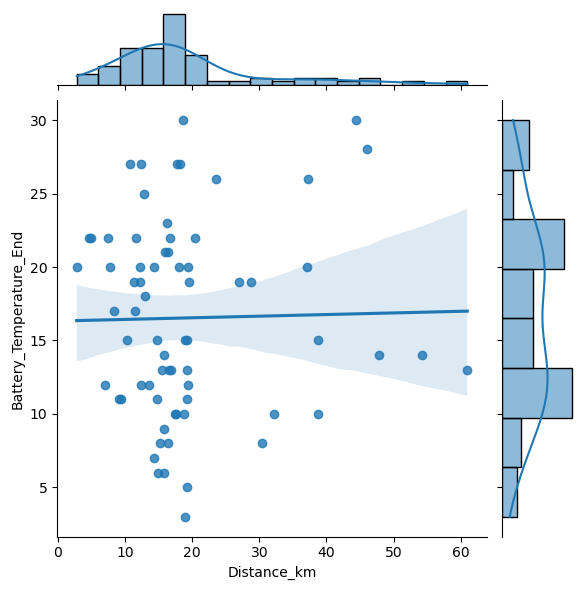

In [42]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Distance_km', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

<Figure size 1000x500 with 0 Axes>

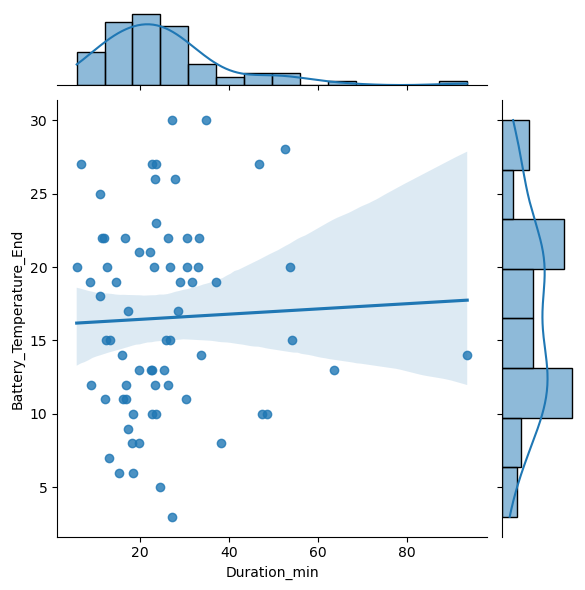

In [43]:
plt.figure(figsize=(10, 5))
sns.jointplot(x='Duration_min', y='Battery_Temperature_End', data=evbattemp, kind='reg');
plt.show()

**Observatons**
- "Battery_Temperature_Start_Celsius" and "Ambient_Temperature_Start_Celsius" have the best linear relationship for "Battery_Temperature_End"

### **Multivariate analysis**
- Let's check the relationship between different numerical variables

<AxesSubplot:>

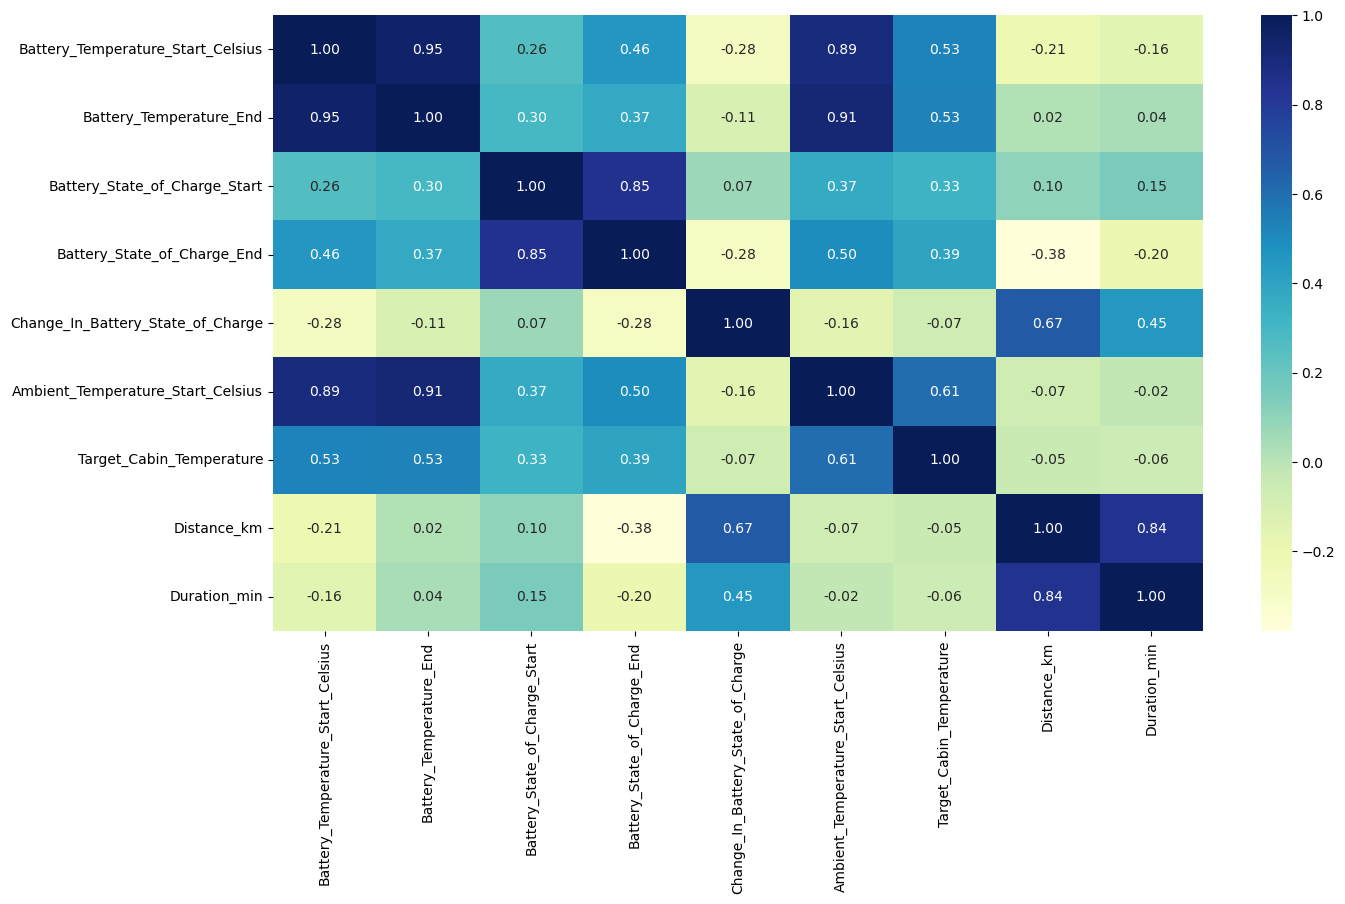

In [44]:
# Plotting the correlation between numerical variables
plt.figure(figsize=(15,8))
sns.heatmap(evbattemp.corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

**Observations:**

- The listed columns have the strongest relationship to column "Battery_Temperature_End" in the following order: **Battery_Temperature_Start_Celsius, Ambient_Temperature_Start_Celsius, Target_Cabin_Temperature, Battery_State_of_Charge_End, Battery_State_of_Charge_Start, Weather** which is easy to understand as these variables show an increase with "Battery_Temperature_Start_Celsius" showing the closest relationship to "Battery_Temperature_End". 
- Columns "Route_Area" and "Distance_km" have the lowest correllation with "Battery_Temperature_End".
- The question relates about distance but we need to remove it as there is no relationship.

### Principal Component Analysis
- used to help determine the reduction of independent variables

In [45]:
# review the data set
evbattemp_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 71
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Battery_Temperature_Start_Celsius  69 non-null     float64
 1   Battery_Temperature_End            69 non-null     float64
 2   Battery_State_of_Charge_Start      69 non-null     float64
 3   Battery_State_of_Charge_End        69 non-null     float64
 4   Change_In_Battery_State_of_Charge  69 non-null     float64
 5   Ambient_Temperature_Start_Celsius  69 non-null     float64
 6   Target_Cabin_Temperature           69 non-null     float64
 7   Distance_km                        69 non-null     float64
 8   Duration_min                       69 non-null     float64
dtypes: float64(9)
memory usage: 5.4 KB


In [46]:
# review the data set shape
evbattemp_numerical.shape[1]

9

In [47]:
#Defining the number of principal components to generate 
n=evbattemp_numerical.shape[1]

#Finding principal components for the data
pca = PCA(n_components=n, random_state=1)
evbattemp_numerical_pca1 = pd.DataFrame(pca.fit_transform(evbattemp_numerical))

#The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_

Text(0, 0.5, 'Cumulative Explained Variance')

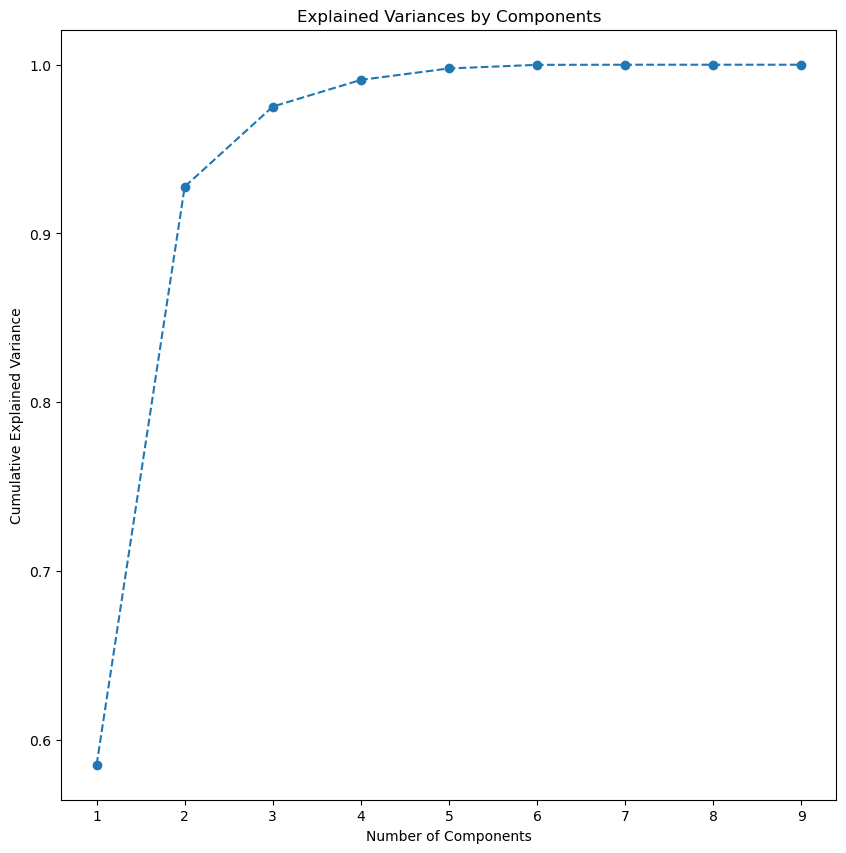

In [48]:
# visualize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,10), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [49]:
# find the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(exp_var):
  sum = sum + i
  if(sum>0.70):
    print("Number of PCs that explain at least 70% variance: ", ix+1)
    break

Number of PCs that explain at least 70% variance:  2


In [50]:
# put data in a dataframe
pc_comps = ['PC1','PC2','PC3','PC4']
data_pca = pd.DataFrame(np.round(pca.components_[:4,:],2),index=pc_comps,columns=evbattemp_numerical.columns)

In [51]:
#review the data
data_pca.T

,PC1,PC2,PC3,PC4
Battery_Temperature_Start_Celsius,-0.12,0.52,-0.03,0.59
Battery_Temperature_End,-0.02,0.46,0.08,0.39
Battery_State_of_Charge_Start,0.00,0.00,-0.00,-0.01
Battery_State_of_Charge_End,-0.00,0.01,-0.01,-0.01
Change_In_Battery_State_of_Charge,0.00,-0.00,0.01,-0.00
Ambient_Temperature_Start_Celsius,-0.07,0.70,0.02,-0.66
Target_Cabin_Temperature,-0.02,0.11,0.04,-0.26
Distance_km,0.60,0.05,0.79,0.02
Duration_min,0.78,0.12,-0.61,0.02


In [52]:
data_pca

,Battery_Temperature_Start_Celsius,Battery_Temperature_End,Battery_State_of_Charge_Start,Battery_State_of_Charge_End,Change_In_Battery_State_of_Charge,Ambient_Temperature_Start_Celsius,Target_Cabin_Temperature,Distance_km,Duration_min
PC1,-0.12,-0.02,0.00,-0.00,0.00,-0.07,-0.02,0.60,0.78
PC2,0.52,0.46,0.00,0.01,-0.00,0.70,0.11,0.05,0.12
PC3,-0.03,0.08,-0.00,-0.01,0.01,0.02,0.04,0.79,-0.61
PC4,0.59,0.39,-0.01,-0.01,-0.00,-0.66,-0.26,0.02,0.02


**Observations:**
- The Principal Component Analysis shows that 2 variables control 70% of the variance, "Distance_km" and "Duration_min", this is because there are more unique data points for these columns though they are not the dependent variables
- It also shows that "Battery_Temperature_Start_Celsius" and "Ambient_Temperature_Start_Celsius" play a factor in variance as well at the next level
- More analysis is needed but it looks like we will need to focus on those 4 columns

## **Data Preparation:**
- Drop Catagory Variables based on Exploratory Data Analysis
- Define your dependent and independent variables
- Perform Variance Inflation Factor to test MultiCollinearity and remove columns that are like that.

**Drop Category Variables**

In [53]:
#create backup of data so far
evbattemp_old_with_categories = evbattemp

In [54]:
# drop the columns "'Route_Area','Fan','Weather'" based Exploratory Data Analysis
evbattemp = evbattemp.drop(['Route_Area','Fan','Weather'], axis=1)

 **Define the dependent variable**

In [55]:
# define dependent and independent variables
independent_variables = evbattemp.drop(['Battery_Temperature_End'], axis = 1)
dependent_variable = evbattemp[['Battery_Temperature_End']]

In [56]:
# Review the data
independent_variables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 71
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Battery_Temperature_Start_Celsius  69 non-null     float64
 1   Battery_State_of_Charge_Start      69 non-null     float64
 2   Battery_State_of_Charge_End        69 non-null     float64
 3   Change_In_Battery_State_of_Charge  69 non-null     float64
 4   Ambient_Temperature_Start_Celsius  69 non-null     float64
 5   Target_Cabin_Temperature           69 non-null     float64
 6   Distance_km                        69 non-null     float64
 7   Duration_min                       69 non-null     float64
dtypes: float64(8)
memory usage: 4.9 KB


In [57]:
# Review the data
independent_variables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 71
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Battery_Temperature_Start_Celsius  69 non-null     float64
 1   Battery_State_of_Charge_Start      69 non-null     float64
 2   Battery_State_of_Charge_End        69 non-null     float64
 3   Change_In_Battery_State_of_Charge  69 non-null     float64
 4   Ambient_Temperature_Start_Celsius  69 non-null     float64
 5   Target_Cabin_Temperature           69 non-null     float64
 6   Distance_km                        69 non-null     float64
 7   Duration_min                       69 non-null     float64
dtypes: float64(8)
memory usage: 4.9 KB


#### **Split the data into train and test**

In [58]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    independent_variables, dependent_variable, test_size = 0.3, random_state = 1
)

**Observation**
- Test size is 30% smaller than the training size

In [59]:
print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])

Number of rows in train data = 48
Number of rows in test data = 21


### **Check for Multicollinearity**

* **Multicollinearity** occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent. If the correlation between variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity in the linear model, the coefficients that the model suggests are unreliable.

* There are different ways of detecting (or testing) multi-collinearity, one such way is the Variation Inflation Factor.

* **Variance Inflation factor**:  Variance inflation factors measures the  inflation in the variances of the regression parameter estimates due to collinearity that exists among the predictors. It is a measure of how much  the variance of the estimated regression coefficient βk is "inflated" by the  existence of correlation among the predictor variables in the model. 

* General Rule of thumb: If VIF is 1 then there is no correlation between the kth predictor and the remaining predictor variables, and  hence the variance of β̂k is not inflated at all. Whereas if **VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.**

In [60]:
# Function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif

In [61]:
# review the data
print(checking_vif(x_train))

                             feature         VIF
0  Battery_Temperature_Start_Celsius   23.059729
1      Battery_State_of_Charge_Start  497.766598
2        Battery_State_of_Charge_End  377.008297
3  Change_In_Battery_State_of_Charge    4.069409
4  Ambient_Temperature_Start_Celsius   16.030310
5           Target_Cabin_Temperature   34.230298
6                        Distance_km   54.688734
7                       Duration_min   19.372317


**Observation**
- There are signs of multi-collinearity in every column except for "Change_In_Battery_State_of_Charge"
- We cane remove "Battery_State_of_Charge_Start" and "Battery_State_of_Charge_End" because they have the highest numbers for multi-collinearity and the "Change_In_Battery_State_of_Charge" is the delta of both columns ("Battery_State_of_Charge_Start" minus "Battery_State_of_Charge_End")

**Drop Columns from Independent Variables**

In [62]:
#create backup of data so far
independent_variables_old = independent_variables

In [63]:
# drop the columns "'Battery_State_of_Charge_Start','Fan','Weather'" based Exploratory Data Analysis
independent_variables = independent_variables.drop(['Battery_State_of_Charge_Start','Battery_State_of_Charge_End'], axis=1)

**Reshape the model since columns were dropped**

In [64]:
#reshape the model after dropping the columns
x_train, x_test, y_train, y_test = train_test_split(
    independent_variables, dependent_variable, test_size = 0.3, random_state = 1
)

In [65]:
print('Number of rows in train data =', x_train.shape[0])
print('Number of rows in test data =', x_test.shape[0])

Number of rows in train data = 48
Number of rows in test data = 21


**Run Variance Inflation Factor again on Independent Variables**

In [66]:
# review the data
print(checking_vif(x_train))

                             feature        VIF
0  Battery_Temperature_Start_Celsius  23.040452
1  Change_In_Battery_State_of_Charge   3.882269
2  Ambient_Temperature_Start_Celsius  13.978525
3           Target_Cabin_Temperature  11.942232
4                        Distance_km  16.153386
5                       Duration_min  13.348368


**Observation**
- Based on the exploratory data analysis, and results from the Variance Inflation Factor, we can use an "OLS" model and/or a "GLM" model because our dependent variable "Battery_Temperature_End" is normally distributed and has linear regressional relationships the independent variables. We will also want to use a "Ridge Regression" model to help with multi-collinearity still left in the independent variables

## **Model Selection**

--------------------
### **Potential techniques** :
--------------------
Since it is a regression problem we will first start with the parametric model - Linear regression and Ridge Regression. 

-------------------
### **Overall solution design** : 
---------------------
The potential solution design would look like this:
* Checking the data description to get the idea of basic statistics or summary of data.
* Univariate analysis to see how data is spread out, getting to know about the outliers.
* Bivariate analysis to see how different attributes vary with the dependent variable.
* Outlier treatment if needed - In this case, outlier treatment is not necessary as outliers are the higher battery temps and in real-world scenarios, such battery temperatures would appear in data and we would want our predictive model to capture the underlying pattern for them.
* Missing value treatment using appropriate techniques.
* Feature engineering - transforming features, creating new features if possible.
* Choosing the model evaluation technique - 1) R Squared 2) RMSE can be any other metrics related to regression analysis.
* Splitting the data and proceeding with modeling.
* Model tuning to see if the performance of the model can be improved further.

-----------------
### **Measures of success** :
-----------------
R-squared and RMSE can be used as a measure of success.

R-squared: This will tell us how much variation our predictive model can explain in data.

RMSE: This will give us a measure of how far off the model is predicting the original values on average.

-------------------
### **Model Building**
------------------
1. What we want to predict is the "Battery_Temperature_End". We will use the normalized version 'Avg_Battery_Temperature_Combined_Celsius_log' for modeling.
2. Before we proceed to the model, we'll confirm if we have to encode categorical features. We will drop categorical features like "Weather". We made this change in the Data Preparation stage. 
3. We'll split the data into train and test, to be able to evaluate the model that we build on the train data.
4. Build Regression models using train data.
5. Evaluate the model performance.


### **Fitting a linear model - Linear Regression**
Linear Regression can be implemented using: <br>

**1) Sklearn:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html <br>
**2) Statsmodels:** https://www.statsmodels.org/stable/regression.html

In [67]:
import statsmodels.api as sm

# Statsmodel api does not add a constant by default. We need to add it explicitly.
x_train = sm.add_constant(x_train)
# Add constant to test data
x_test = sm.add_constant(x_test)


def build_ols_model(train):
    # Create the model
    olsmodel = sm.OLS(y_train['Battery_Temperature_End'], train)
    return olsmodel.fit()


olsmodel1 = build_ols_model(x_train)
print(olsmodel1.summary())

                               OLS Regression Results                              
Dep. Variable:     Battery_Temperature_End   R-squared:                       0.953
Model:                                 OLS   Adj. R-squared:                  0.946
Method:                      Least Squares   F-statistic:                     138.3
Date:                     Sun, 19 Feb 2023   Prob (F-statistic):           1.38e-25
Time:                             16:49:44   Log-Likelihood:                -86.204
No. Observations:                       48   AIC:                             186.4
Df Residuals:                           41   BIC:                             199.5
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

* Both the R-squared and Adjusted R squared of our model is high. We will have to comfirm this model through additional analysis.
* It is very possible with limited amount of data (total of 69 records) is causing the model to be an overfitting model.
* To be able to make statistical inferences from our model, we will have to test that the linear regression assumptions are followed.
* Before we move on to assumption testing, we'll do a quick performance check on the test data.

In [68]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test):

    # Insample Prediction
    y_pred_train_pricelog = model.predict(x_train)
    y_pred_train_Price = y_pred_train_pricelog.apply(math.exp)
    y_train_Price = y_train['Battery_Temperature_End']

    # Prediction on test data
    y_pred_test_pricelog = model.predict(x_test)
    y_pred_test_Price = y_pred_test_pricelog.apply(math.exp)
    y_test_Price = y_test['Battery_Temperature_End']

    print(
        pd.DataFrame(
            {
                'Data': ['Train', 'Test'],
                'RMSE': [
                    rmse(y_pred_train_Price, y_train_Price),
                    rmse(y_pred_test_Price, y_test_Price),
                ],
                'MAE': [
                    mae(y_pred_train_Price, y_train_Price),
                    mae(y_pred_test_Price, y_test_Price),
                ],
                'MAPE': [
                    mape(y_pred_train_Price, y_train_Price),
                    mape(y_pred_test_Price, y_test_Price),
                ],
            }
        )
    )


# Checking model performance
model_pref(olsmodel1, x_train, x_test)  # High Overfitting.

    Data          RMSE           MAE          MAPE
0  Train  1.724616e+13  2.571558e+12  8.591668e+12
1   Test  4.402158e+09  1.622664e+09  6.594361e+09


* Root Mean Squared Error of train and test data has a slight difference, indicating that our model is mostly fine but probaby underfitting the train data. 
* Mean Absolute Error indicates that our current model can predict used "Battery_Temperature_End" within a mean error of 3.8 temperature Celsius on test data.
* The units of both RMSE and MAE are the same - temperature Celsius in this case. But RMSE is greater than MAE because it penalizes the outliers more.
* Mean Absolute Percentage Error is ~36% on the test data.

**Checking the Linear Regression Assumptions**

1. No Multicollinearity
2. Mean of residuals should be 0
3. No Heteroscedasticity
4. Linearity of variables
5. Normality of error terms

**Checking Assumption 1: No Multicollinearity**

- We will use VIF, to check if there is multicollinearity in the data.

- Features having a VIF score >5 will be dropped/treated till all the features have a VIF score <5.

In [69]:
# execute the function for Variance Inflation Factor to test for Multi-Collinearity
print(checking_vif(x_train))

                             feature         VIF
0                              const  105.535127
1  Battery_Temperature_Start_Celsius    5.326492
2  Change_In_Battery_State_of_Charge    1.648089
3  Ambient_Temperature_Start_Celsius    5.637233
4           Target_Cabin_Temperature    1.400495
5                        Distance_km    4.551924
6                       Duration_min    3.484832


- only one column that matches this and I am not concerned about it
- confirms the "Distance_km" is not needed in the prediction, but not bad enough to remove it as it is right on the threshold

#### **Checking Assumption 2: Mean of residuals should be 0**

In [70]:
residuals = olsmodel1.resid
np.mean(residuals)

1.3415194880887308e-14

- Mean of redisuals is very close to 0. The second assumption is also satisfied.

#### **Checking Assumption 3: No Heteroscedasticity**

* Homoscedacity - If the residuals are symmetrically distributed across the regression line, then the data is said to be homoscedastic.

* Heteroscedasticity- - If the residuals are not symmetrically distributed across the regression line, then the data is said to be heteroscedastic. In this case, the residuals can form a funnel shape or any other non-symmetrical shape.

We'll use **`Goldfeldquandt Test`** to test the following hypothesis

> **Null hypothesis: Residuals are homoscedastic**

> **Alternate hypothesis: Residuals have heteroscedasticity**

> **alpha = 0.05** 

In [71]:
from statsmodels.compat import lzip

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, x_train)
lzip(name, test)

[('F statistic', 0.26432234990525555), ('p-value', 0.995519845352357)]

- Since the p-value > 0.05 we cannot reject the Null Hypothesis that the residuals are homoscedastic. 

- Assumptions 3 is also satisfied by our olsmodel1.

**Checking Assumption 4: Linearity of variables**

Predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

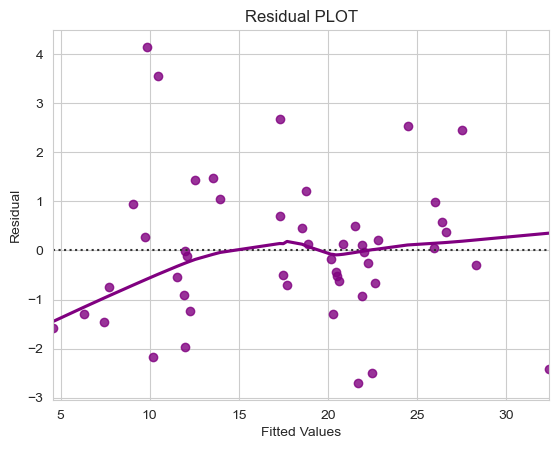

In [72]:
# Predicted values
fitted = olsmodel1.fittedvalues
#fitted.info()
#residuals.info()
#print(fitted)
#print(residuals)
fitted_residuals = pd.DataFrame.assign({ 'fitted': fitted, 
    'residuals': residuals})
#print(fitted_residuals['residuals'])
#fitted_residuals['fitted'].astype('float64') = fitted[1]
#fitted_residuals['residuals'].astype('float64') = residuals[1]

sns.set_style("whitegrid")
sns.residplot(fitted_residuals,x='fitted', y='residuals', color = "purple", lowess = True)

plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residual PLOT')
plt.show()

#### **Checking Assumption 5: Normality of error terms**

The residuals should be normally distributed.

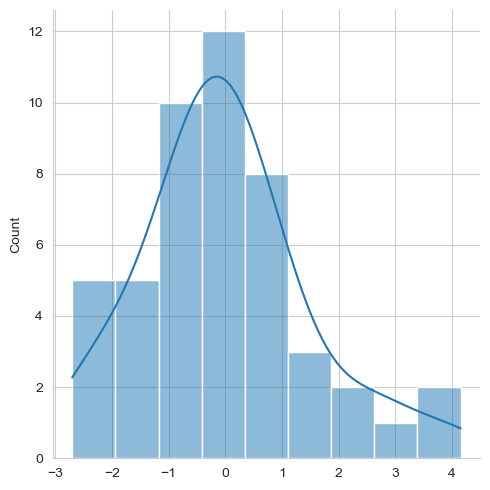

In [73]:
# Plot histogram of residuals
sns.displot(residuals, kde=True)

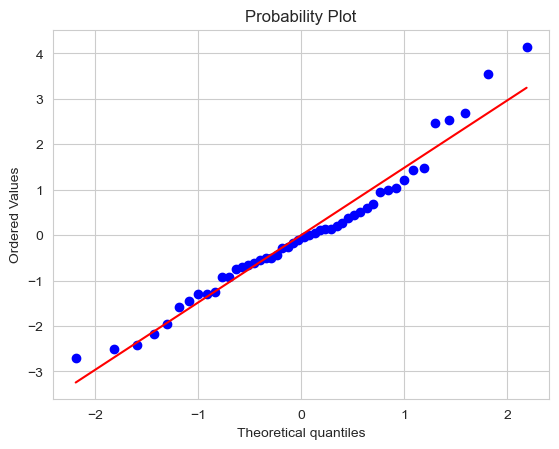

In [74]:
# Plot q-q plot of residuals
import pylab


scipy.stats.probplot(residuals, dist = 'norm', plot = pylab)
plt.show()

- The residuals have a close to normal distribution. Assumption 5 is also satisfied.
- We should further investigate these values in the tails where we have made huge residual errors.

**Now that we have seen that olsmodel1 follows all the linear regression assumptions. Let us use that model to draw inferences.**

In [75]:
print(olsmodel1.summary())

                               OLS Regression Results                              
Dep. Variable:     Battery_Temperature_End   R-squared:                       0.953
Model:                                 OLS   Adj. R-squared:                  0.946
Method:                      Least Squares   F-statistic:                     138.3
Date:                     Sun, 19 Feb 2023   Prob (F-statistic):           1.38e-25
Time:                             16:49:44   Log-Likelihood:                -86.204
No. Observations:                       48   AIC:                             186.4
Df Residuals:                           41   BIC:                             199.5
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

#### **Observations from the model**

to tired,  will do it later

In [76]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # Import methods to build linear model for statistical analysis and prediction

from sklearn.tree import DecisionTreeRegressor                   # Import methods to build decision trees.
from sklearn.ensemble import RandomForestRegressor               # Import methods to build Random Forest.

from sklearn import metrics                                      # Metrics to evaluate the model

from sklearn.model_selection import GridSearchCV                 # For tuning the model

In [77]:
##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag = True):
    '''
    model : regressor to predict values of X

    '''
    # Defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(X_train)
    pred_train_ = np.exp(pred_train)
    pred_test = model.predict(X_test)
    pred_test_ = np.exp(pred_test)

    train_r2 = metrics.r2_score(y_train['Battery_Temperature_End'], pred_train_)
    test_r2 = metrics.r2_score(y_test['Battery_Temperature_End'], pred_test_)
    train_rmse = metrics.mean_squared_error(
        y_train['Battery_Temperature_End'], pred_train_, squared = False
    )
    test_rmse = metrics.mean_squared_error(y_test['Battery_Temperature_End'], pred_test_, squared = False)

    # Adding all scores in the list
    score_list.extend((train_r2, test_r2, train_rmse, test_rmse))

    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag == True:
        print(
            'R-sqaure on training set : ',
            metrics.r2_score(y_train['Battery_Temperature_End'], pred_train_),
        )
        print('R-square on test set : ', metrics.r2_score(y_test['Battery_Temperature_End'], pred_test_))
        print(
            'RMSE on training set : ',
            np.sqrt(metrics.mean_squared_error(y_train['Battery_Temperature_End'], pred_train_)),
        )
        print(
            'RMSE on test set : ',
            np.sqrt(metrics.mean_squared_error(y_test['Battery_Temperature_End'], pred_test_)),
        )

    # Returning the list with train and test scores
    return score_list

### **Ridge Regression**
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [78]:
# Create a Ridge regression model
rdg = Ridge()

In [79]:

# split a new data set
X_train, X_test, y_train, y_test = train_test_split(
    independent_variables, dependent_variable, test_size = 0.3, random_state = 1
)

In [80]:
print('Number of rows in train data =', X_train.shape[0])
print('Number of rows in test data =', X_test.shape[0])
print('Number of rows in train data =', y_train.shape[0])
print('Number of rows in test data =', y_test.shape[0])
print(y_test)

Number of rows in train data = 48
Number of rows in test data = 21
Number of rows in train data = 48
Number of rows in test data = 21
    Battery_Temperature_End
66                     12.0
31                     26.0
26                     22.0
39                     13.0
68                     13.0
50                     15.0
38                     11.0
59                     15.0
52                      8.0
2                      25.0
41                     10.0
51                      6.0
36                     12.0
56                     10.0
27                     19.0
64                      8.0
54                      9.0
55                     13.0
49                     13.0
47                     13.0
35                     15.0


In [81]:
# Fit Ridge regression model.
rdg.fit(X_train, y_train['Battery_Temperature_End'])

Ridge()

In [82]:
# Get score of the model.
Ridge_score = get_model_score(rdg)

R-sqaure on training set :  -6.60152351190644e+24
R-square on test set :  -7.217982078681247e+17
RMSE on training set :  17261507729631.094
RMSE on test set :  4427356550.574545


**Observations**
- Ridge regression is able to produce better results compared to Linear Regression.

### **Decision Tree**
https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

In [83]:
# Create a decision tree regression model
dtree = DecisionTreeRegressor(random_state = 1)

In [84]:
# Fit decision tree regression model.
dtree.fit(X_train, y_train['Battery_Temperature_End'])

DecisionTreeRegressor(random_state=1)

In [85]:
# Get score of the model.
Dtree_model = get_model_score(dtree)

R-sqaure on training set :  -1.0693105980510441e+23
R-square on test set :  -4.965445549120466e+20
RMSE on training set :  2196891332738.4624
RMSE on test set :  116122321830.3499


**Observations**
- Decision Tree is overfitting on the training set and hence not able to generalize well on the test set.

Print the importance of features in the tree building ( The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the **Gini importance** )

In [86]:
print(
    pd.DataFrame(
        dtree.feature_importances_, columns = ['Imp'], index = X_train.columns
    ).sort_values(by = 'Imp', ascending = False)
)

                                        Imp
Battery_Temperature_Start_Celsius  0.914057
Ambient_Temperature_Start_Celsius  0.058118
Distance_km                        0.019375
Duration_min                       0.005665
Target_Cabin_Temperature           0.001846
Change_In_Battery_State_of_Charge  0.000939


**Observations**
- Ambient_Temperature_Start_Celsius, Duration_min and Avg_Battery_State_of_Charge_Combined are the top 3 important features of decision tree model.

### **Random Forest**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [87]:
# Create a Random Forest regression model 
rf = RandomForestRegressor(random_state = 1, oob_score = True)

In [88]:
# Fit Random Forest regression model.
rf.fit(X_train, y_train['Battery_Temperature_End'])

RandomForestRegressor(oob_score=True, random_state=1)

In [89]:
# Get score of the model.
RandomForest_model = get_model_score(rf)

R-sqaure on training set :  -2.4840524856979326e+22
R-square on test set :  -8.042998569935212e+19
RMSE on training set :  1058856297219.1505
RMSE on test set :  46735360246.38385


**Observations**
- Random Forest model has performed well on training and test set and we can see the model has overfitted slightly.

**Feature Importance**

Print the importance of features in the tree building ( The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the **Gini importance** )

In [90]:
print(
    pd.DataFrame(
        rf.feature_importances_, columns = ['Imp'], index = X_train.columns
    ).sort_values(by = 'Imp', ascending = False)
)

                                        Imp
Battery_Temperature_Start_Celsius  0.739358
Ambient_Temperature_Start_Celsius  0.236258
Distance_km                        0.010474
Change_In_Battery_State_of_Charge  0.007495
Duration_min                       0.004671
Target_Cabin_Temperature           0.001744


**Observations**
- Ambient_Temperature_Start_Celsius, Route_Area and Weather are the top 3 important features of decision tree model.